In [1]:
import numpy as np
import matplotlib.pyplot as plt
import burst_detector as bd
import seaborn as sns
from scipy.stats import wasserstein_distance
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
n_chan = 128
times = np.load('../data/midbrain_cullen/KS2.5_preprocessed/spike_times.npy').flatten()
clusters = np.load('../data/midbrain_cullen/KS2.5_preprocessed/spike_clusters.npy').flatten()
clus_table = np.load('../data/midbrain_cullen/KS2.5_preprocessed/clus_table.npy').flatten()
# mean_wf = np.load("../data/midbrain_cullen/KS2.5_preprocessed/mean_waveforms.npy")

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv("../data/midbrain_cullen/KS2.5_preprocessed/cluster_group.tsv", sep="\t")

In [3]:
# load raw data
rawData = np.memmap("../data/midbrain_cullen/NPX_001_Session_2_preprocessed.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [5]:
# Calculate mean waveforms
n_clust = clusters.max() + 1
mean_wf = np.zeros((n_clust, n_chan, 82))

for i in range(n_clust):
    if i in np.unique(clusters):
        spikes = bd.extract_spikes(data, times, clusters, i, n_chan=128)
        mean_wf[i,:,:] = spikes.mean(axis=0)
    
    if i % 10 == 0:
        print("Done with %d" %i)

np.save("midbrain_mean_wf", mean_wf)

Done with 0
Done with 10
Done with 20
Done with 30
Done with 40
Done with 50
Done with 60
Done with 70
Done with 80
Done with 90
Done with 100
Done with 110
Done with 120
Done with 130


In [181]:
offsets = np.zeros((n_clust))

for i in range(n_clust):
    if labels.iloc[i]['group']=='good':
        offsets[i] = np.unravel_index(np.argmin(mean_wf[i,:,:25]),wf_means_norm[i,:,:25].shape)[1]

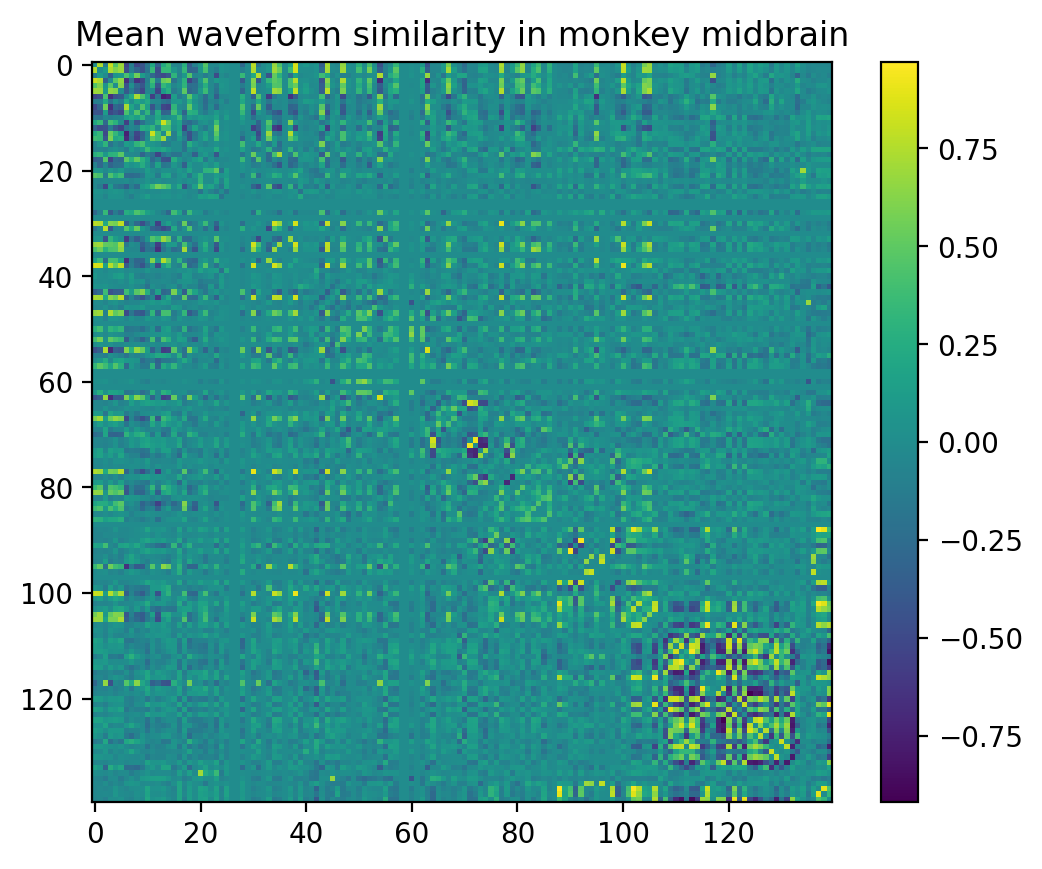

In [6]:
mean_sim, wf_means_norm = bd.wf_means_similarity(mean_wf)
plt.imshow(mean_sim)
plt.colorbar(); plt.title("Mean waveform similarity in monkey midbrain");

In [7]:
sim_thresh = 0.4
sp_num_thresh = 100

In [8]:
# params for merge candidates
num  = 0


wass_d = np.ones_like(mean_sim)


for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
        # if (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                
                #extract spikes
                sp_1 = bd.extract_spikes(data, times, clusters, c1, n_chan=n_chan)
                sp_2 = bd.extract_spikes(data, times, clusters, c2, n_chan=n_chan)
                
                # compute cross-projections
                proj_1on1, proj_2on1, proj_1on2, proj_2on2 = bd.cross_proj(sp_1, sp_2, wf_means_norm[c1], wf_means_norm[c2])
                
                # compute wasserstein distances
                dist_1on2 = proj_1on2/proj_1on1
                dist_1on2[dist_1on2 > 1] = 1
                dist_1on2[dist_1on2 < -1] = -1
                
                dist_2on1 = proj_2on1/proj_2on2
                dist_2on1[dist_2on1 > 1] = 1
                dist_2on1[dist_2on1 < -1] = -1
                
                wass_d[c1, c2] = wasserstein_distance(proj_1on1/proj_1on1, dist_1on2)
                wass_d[c2, c1] = wasserstein_distance(proj_2on2/proj_2on2, dist_2on1)
                
                num += 1
                if (num % 10 == 0):
                    print("finished pair %d" % num)
                    
np.save("midbrain_cullen_NPXL1_S2_wass_d.npy", wass_d)

finished pair 10
finished pair 20
finished pair 30
finished pair 40
finished pair 50
finished pair 60
finished pair 70
finished pair 80
finished pair 90
finished pair 100
finished pair 110
finished pair 120


In [ ]:
pass_1 = np.zeros_like(mean_sim, dtype='bool')
for c1 in range(counts.shape[0]): 
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                pass_1[c1,c2] = True
                pass_1[c2,c1] = True

Text(0.5, 1.0, '1 - Wasserstein distance in monkey midbrain')

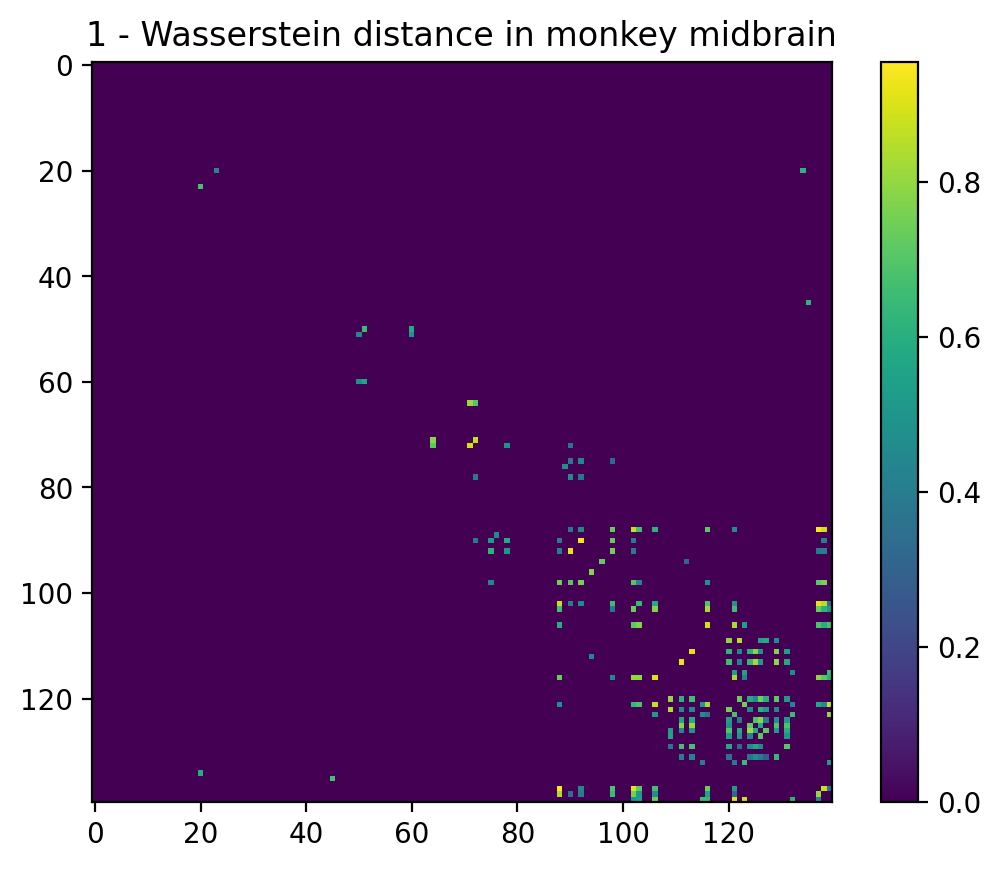

In [9]:
plt.imshow(1-wass_d)
plt.colorbar(); plt.title("1 - Wasserstein distance in monkey midbrain")

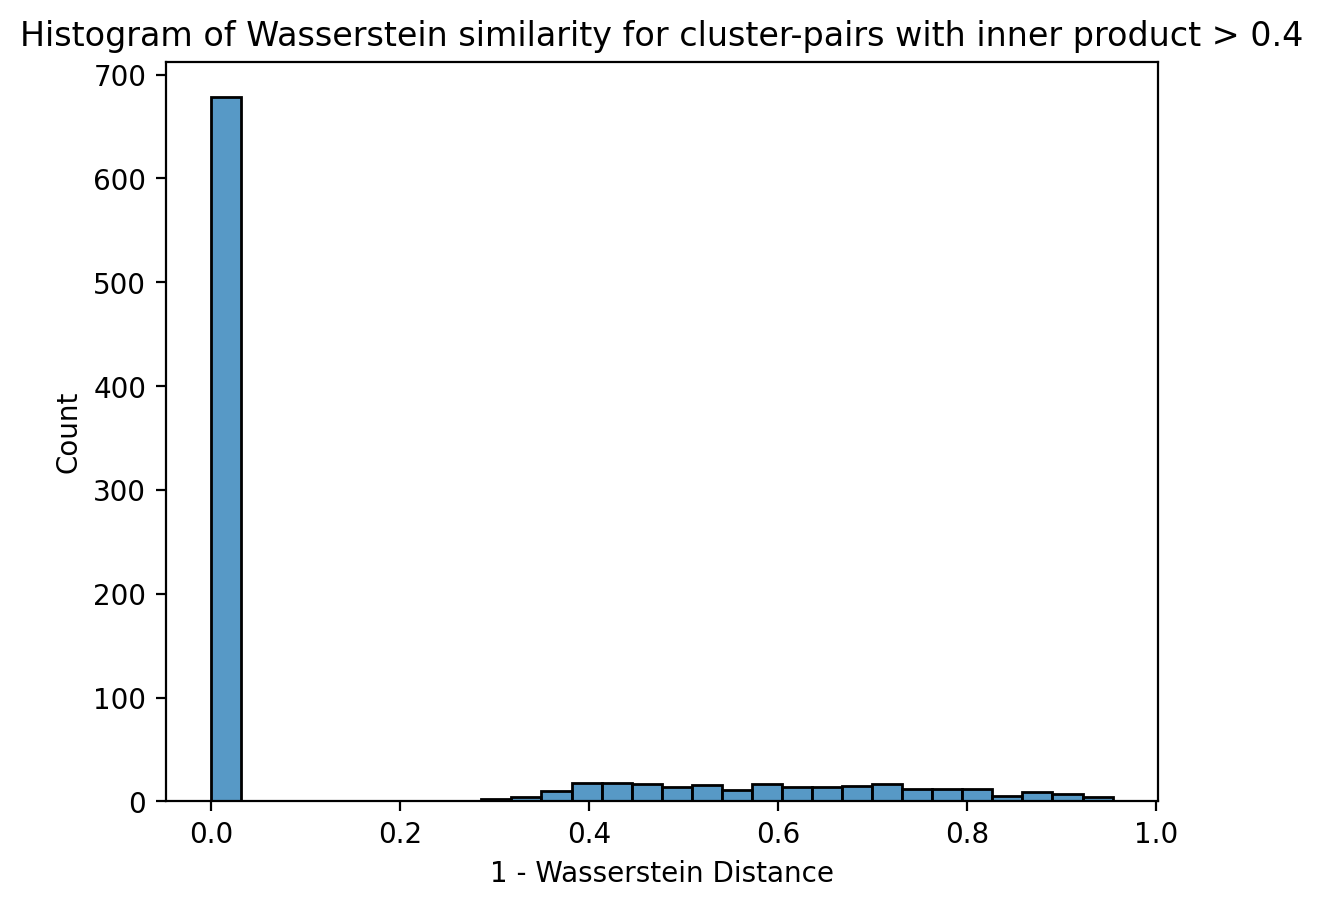

In [10]:
wass_sim = 1 - wass_d
sns.histplot(wass_sim.flatten()[mean_sim.flatten() >= sim_thresh], bins=30);

plt.xlabel("1 - Wasserstein Distance");
plt.title("Histogram of Wasserstein similarity for cluster-pairs with inner product > 0.4");

In [208]:
wass_sim = 1-wass_d

merge_dec = np.zeros_like(mean_sim)
wass_thresh = 0.7
num = 0

for c1 in range(counts.shape[0]): 
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                if (wass_sim[c1, c2] * wass_sim[c2, c1] > wass_thresh**2):
                    merge_dec[c1, c2] = 1
                    merge_dec[c2, c1] = 1                

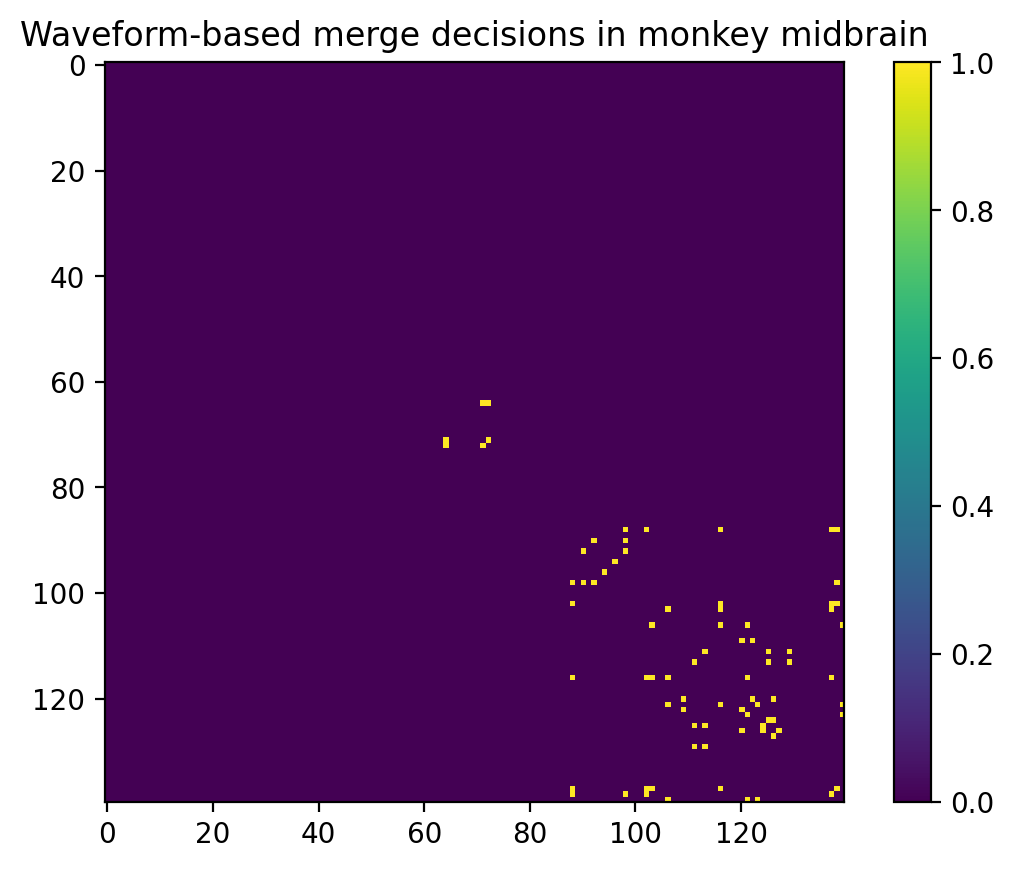

In [209]:
plt.imshow(merge_dec)
plt.colorbar();
plt.title("Waveform-based merge decisions in monkey midbrain");